In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [3]:
df = pd.read_csv("../data/Twitter_volume_UPS.txt", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)
df.tail(5)

(15866, 2)


,timestamp,value
15861,2015-04-22 23:27:53,3
15862,2015-04-22 23:32:53,2
15863,2015-04-22 23:37:53,2
15864,2015-04-22 23:42:53,3
15865,2015-04-22 23:47:53,3


In [4]:
df.head(5)

,timestamp,value
0,2015-02-26 21:42:53,2
1,2015-02-26 21:47:53,2
2,2015-02-26 21:52:53,4
3,2015-02-26 21:57:53,3
4,2015-02-26 22:02:53,5


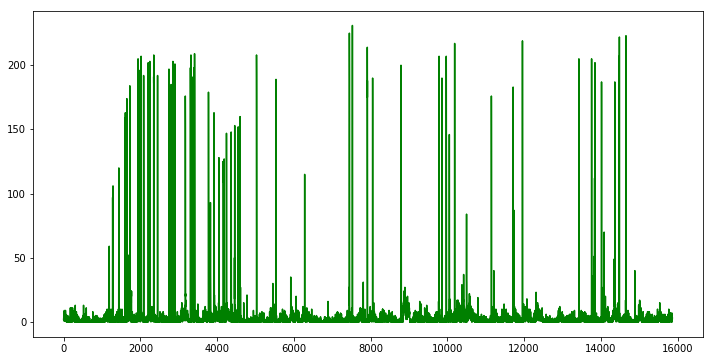

In [100]:
data=df['value']

plt.figure(figsize=(12,6))
plt.plot(data,color="green")

In [101]:
train=df[df['value']<100]
train=train['value']
train=np.array(train)
timesquence=10
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
print("train",train.shape)

train (1561, 10, 1)


In [102]:
test=df['value']
test=test[1:3000]
test_label=[]

for i in range(len(test)):
    if(test.iloc[i]>100 ):
        test_label.append(1)
    else:
        test_label.append(0)
            
print(len(test_label))
test=np.array(test)
trim=len(test)%timesquence
test_label=test_label[:len(test)-trim]
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)
print("test",test.shape)

2999
test (299, 10, 1)


In [604]:
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(5)] 
# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
              kernel_regularizer=regularizers.l2(0.02),
               padding='causal',
               dilation_rate=dilation_rate,activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

TCN = Model(history_seq, pred_seq_train)
TCN.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
TCN.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, None, 1)           0         
_________________________________________________________________
conv1d_96 (Conv1D)           (None, None, 32)          96        
_________________________________________________________________
conv1d_97 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_98 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_99 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_100 (Conv1D)          (None, None, 32)          2080      
_________________________________________________________________
dense_39 (Dense)             (None, None, 128)         422

In [605]:
from keras.callbacks import TensorBoard
tensorboard=tensorflow.keras.callbacks.TensorBoard(histogram_freq=1)
history=TCN.fit(train, train,
          batch_size=2**11,
           epochs=42,#20        
                validation_data=(test, test))
         # callbacks = [tensorboard])


Train on 1561 samples, validate on 299 samples
Epoch 1/42
1561/1561 [==============================] - 5s 3ms/step - loss: 5.4346 - val_loss: 10.4632
Epoch 2/42
1561/1561 [==============================] - 1s 374us/step - loss: 5.3886 - val_loss: 10.4077
Epoch 3/42
1561/1561 [==============================] - 1s 388us/step - loss: 5.3445 - val_loss: 10.3523
Epoch 4/42
1561/1561 [==============================] - 1s 384us/step - loss: 5.3000 - val_loss: 10.2972
Epoch 5/42
1561/1561 [==============================] - 1s 381us/step - loss: 5.2557 - val_loss: 10.2418
Epoch 6/42
1561/1561 [==============================] - 1s 364us/step - loss: 5.2114 - val_loss: 10.1850
Epoch 7/42
1561/1561 [==============================] - 1s 371us/step - loss: 5.1665 - val_loss: 10.1269
Epoch 8/42
1561/1561 [==============================] - 1s 345us/step - loss: 5.1214 - val_loss: 10.0667
Epoch 9/42
1561/1561 [==============================] - 1s 360us/step - loss: 5.0750 - val_loss: 10.0038
Epoch 10/4

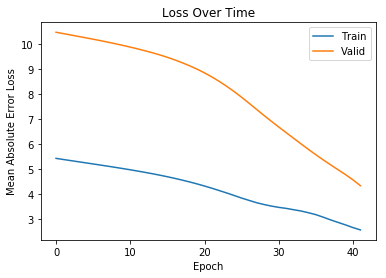

In [606]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [607]:
test_pred = TCN.predict(test)
print(test_pred.shape)
# print(test[0:5])
# print("-------------------------")
# print(test_pred[0:5])


(299, 10, 1)


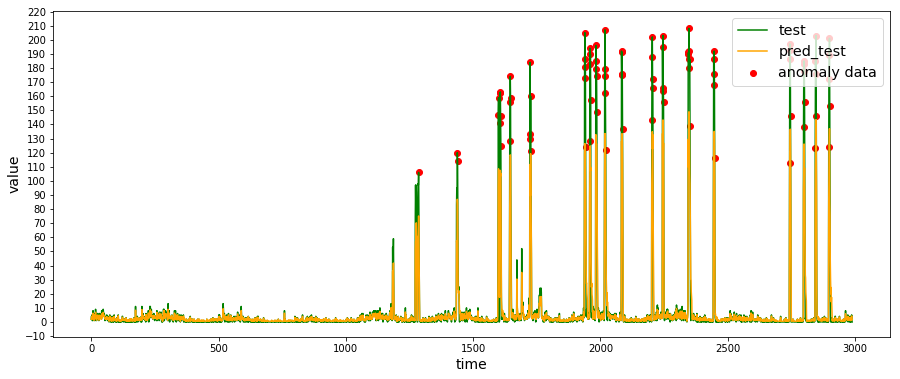

In [608]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(10)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,2)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')

for i in range(len(test1)):
    if test_label[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [697]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[1.42097473e-04 2.26020813e-04 5.63383102e-04 ... 8.12593155e+01
 8.14052200e+01 8.29323578e+01]


In [673]:
print(PAscores[500])

0.22405600547790527


In [698]:
PAcutoff=int(0.965*len(PAscores))#965
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

25.906230926513672


In [699]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [700]:
normal_rela_erro=0.15
#集体集检测
timestep=3
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[ 0.14202857  0.15195823  0.25247836  0.26071656  0.28523386  0.35371666
  0.35771263  0.36318386  0.37265766  0.3942802   0.39550519  0.39550519
  0.40158534  0.41276193  0.41276193  0.42718494  0.42795646  0.42922664
  0.45        0.45        0.45        0.45        0.45        0.45
  0.45        0.45        0.45        0.45        0.45        0.45
  0.45        0.45        0.45        0.45        0.45        0.45
  0.45188832  0.47144413  0.47835588  0.4949249   0.50087309  0.51297688
  0.53017616  0.5334971   0.53758013  0.53997731  0.54005897  0.55279617
  0.55426037  0.55426037  0.55783939  0.55795324  0.56598215  0.56699157
  0.56755388  0.57719612  0.58369708  0.58518231  0.58587837  0.62439156
  0.62674558  0.63047731  0.63966393  0.64151955  0.64336634  0.65310204
  0.67431288  0.67616534  0.67640996  0.68509698  0.68599558  0.68814659
  0.68971801  0.70082259  0.70292127  0.70531917  0.70974803  0.7102704
  0.7102704   0.71633458  0.72739315  0.72936177  0.73138618  0.732569

In [701]:
CAcutoff=int(0.998*len(CAscores))#0.998
CAthreshold=CAscores[CAcutoff]
print(CAthreshold)

44.54898300170898


In [702]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [703]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

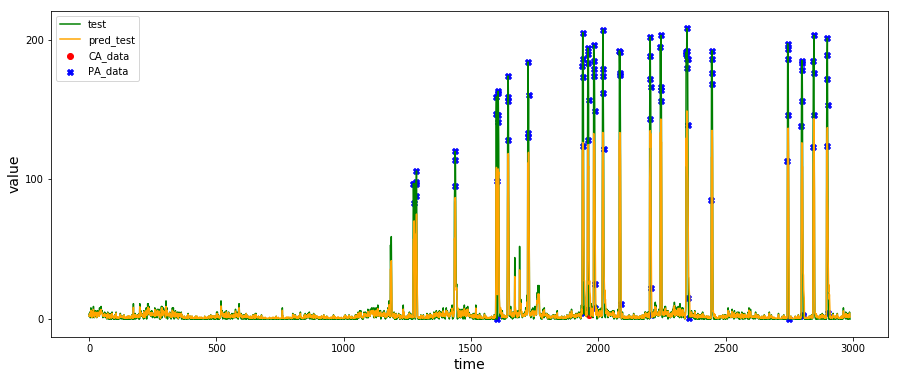

In [704]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [705]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [706]:
print(Pred_label.count(1))
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

110
CA: 3
PA: 107
ROC_AUC score:97.236113%
PR-AUC score:85.495312%


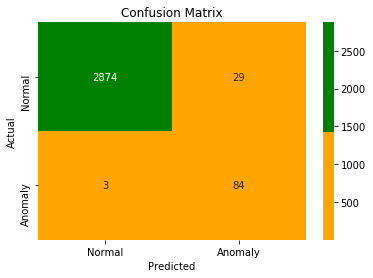

In [696]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)